In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Configuração de Estilo para Artigo Científico
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [29]:
dataset = pd.read_csv('resultados_consolidados.csv')
dataset.head(201)

,Cenário,Usuários,Média Latência (ms),Máxima Latência (ms),Requisições/s,Erros (%)
0,Leve,50,19.74,1463.74,24.76,0.0000
1,Moderado,100,50.20,10082.75,48.75,53.9923
2,Pico,200,81.81,10174.99,96.09,68.8738


--- Tabela Consolidada (Média das Repetições) ---
| Cenário   |   Usuários (u) |   Média Latência (ms) |   Máxima Latência (ms) |   Requisições/s |   Erros (%) |
|:----------|---------------:|----------------------:|-----------------------:|----------------:|------------:|
| Leve      |             50 |                 19.74 |                1463.74 |           24.76 |      0      |
| Moderado  |            100 |                 50.2  |               10082.8  |           48.75 |     53.9923 |
| Pico      |            200 |                 81.81 |               10175    |           96.09 |     68.8738 |


/tmp/ipykernel_13284/3376023273.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Usuários (u)', y='Média Latência (ms)', data=df_consolidado, palette='viridis')


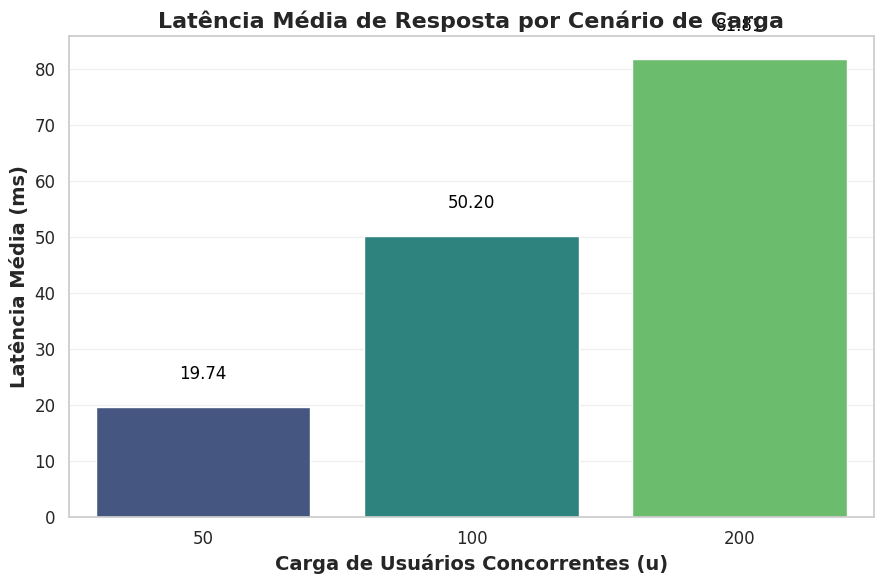

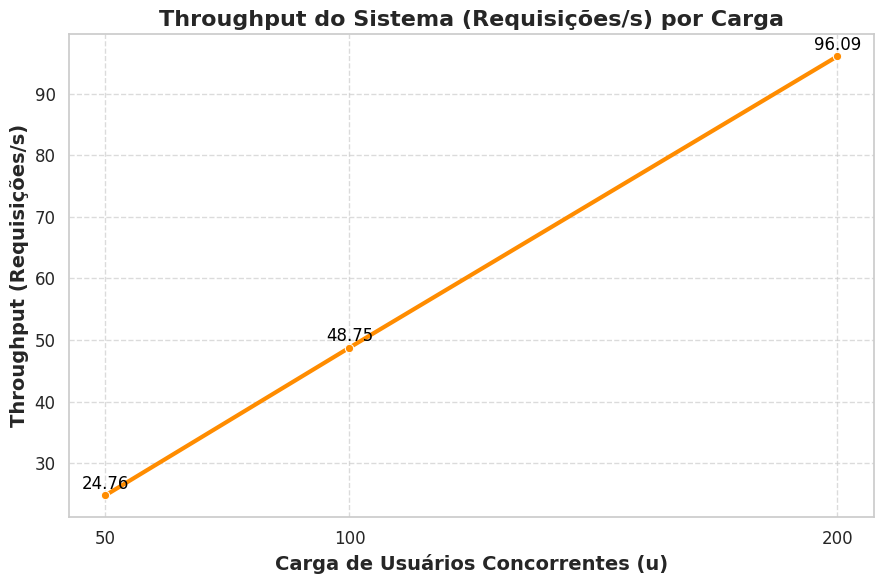

/tmp/ipykernel_13284/3376023273.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cenário', y='Erros (%)', data=df_consolidado, palette='Reds')


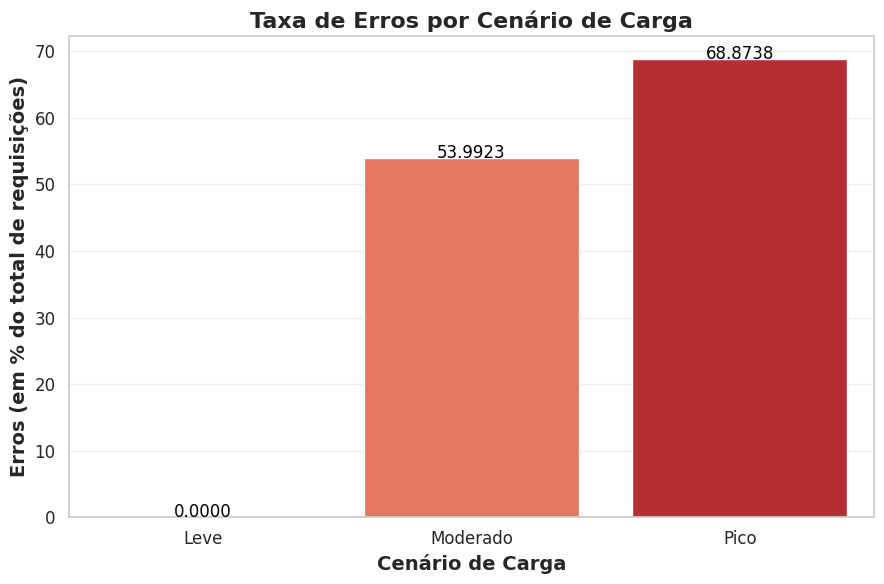

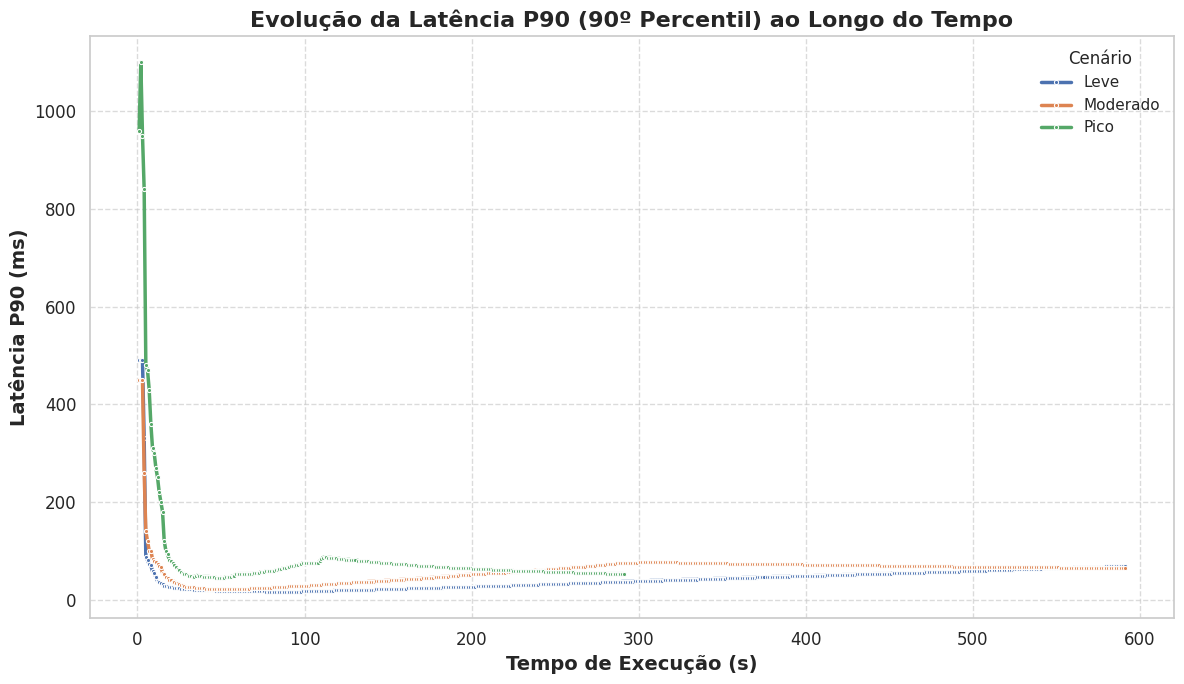

In [30]:
# Diretórios
BASE_DIR = os.getcwd()
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

# Definindo a contagem de usuários para cada cenário
SCENARIOS = {
    "Leve": {"users": 50, "pattern": "results/leve/*_stats.csv"},
    "Moderado": {"users": 100, "pattern": "results/medio/*_stats.csv"},
    "Pico": {"users": 200, "pattern": "results/pico/*_stats.csv"}
}

def load_and_aggregate_results(scenarios):
    """Carrega, processa e agrega os dados de todas as repetições."""
    RESULT_METRICS = []
    
    for scenario, data in scenarios.items():
        pattern = data["pattern"]
        users = data["users"]
        all_files = glob.glob(pattern)
        
        if not all_files:
            print(f"Aviso: Nenhum arquivo encontrado para o cenário {scenario}.")
            continue

        df_list = []
        for f in all_files:
            try:
                df = pd.read_csv(f)
                aggregated_row = df.loc[df['Name'] == 'Aggregated']
                if not aggregated_row.empty:
                    df_list.append(aggregated_row)
            except Exception as e:
                print(f"Erro ao processar o arquivo {f}: {e}")
                
        if not df_list:
            continue

        combined_df = pd.concat(df_list)

        # Converte e Limpa Colunas (essencial para evitar KeyErrors e NaN)
        for col in ['Average Response Time', 'Max Response Time', 'Requests/s', 'Failure Count', 'Request Count']:
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

        # Cálculos de Agregação
        avg_latency = combined_df['Average Response Time'].mean().round(2)
        max_latency_absolute = combined_df['Max Response Time'].max().round(2) # Pior caso absoluto
        avg_req_s = combined_df['Requests/s'].mean().round(2)
        
        total_requests = combined_df['Request Count'].sum()
        total_failures = combined_df['Failure Count'].sum()
        
        avg_failure_rate = (total_failures / total_requests) * 100 if total_requests > 0 else 0.0

        avg_data = {
            'Cenário': scenario,
            'Usuários (u)': users,
            'Média Latência (ms)': avg_latency,
            'Máxima Latência (ms)': max_latency_absolute,
            'Requisições/s': avg_req_s,
            'Erros (%)': round(avg_failure_rate, 4)
        }
        RESULT_METRICS.append(avg_data)

    return pd.DataFrame(RESULT_METRICS)

df_consolidado = load_and_aggregate_results(SCENARIOS)
print("--- Tabela Consolidada (Média das Repetições) ---")
print(df_consolidado.to_markdown(index=False))

# ## 2. Geração de Gráficos de Desempenho

# ### 2.1 Latência Média vs. Carga (Métrica de Qualidade)

plt.figure(figsize=(9, 6))
sns.barplot(x='Usuários (u)', y='Média Latência (ms)', data=df_consolidado, palette='viridis')
plt.title('Latência Média de Resposta por Cenário de Carga')
plt.xlabel('Carga de Usuários Concorrentes (u)')
plt.ylabel('Latência Média (ms)')

# Adiciona o valor exato no topo de cada barra
for index, row in df_consolidado.iterrows():
    plt.text(row.name, row['Média Latência (ms)'] + 5, f"{row['Média Latência (ms)']:.2f}", color='black', ha="center")

plt.tight_layout()
plt.show()


# ### 2.2 Throughput (Req/s) vs. Carga (Métrica de Capacidade)

plt.figure(figsize=(9, 6))
sns.lineplot(x='Usuários (u)', y='Requisições/s', data=df_consolidado, marker='o', color='darkorange', linewidth=3)

# Adiciona o valor exato nos pontos
for index, row in df_consolidado.iterrows():
    plt.text(row['Usuários (u)'], row['Requisições/s'] + 1, f"{row['Requisições/s']:.2f}", color='black', ha="center")

plt.title('Throughput do Sistema (Requisições/s) por Carga')
plt.xlabel('Carga de Usuários Concorrentes (u)')
plt.ylabel('Throughput (Requisições/s)')
plt.xticks(df_consolidado['Usuários (u)'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ### 2.3 Taxa de Erros vs. Carga (Métrica de Estabilidade)

plt.figure(figsize=(9, 6))
sns.barplot(x='Cenário', y='Erros (%)', data=df_consolidado, palette='Reds')
plt.title('Taxa de Erros por Cenário de Carga')
plt.xlabel('Cenário de Carga')
plt.ylabel('Erros (em % do total de requisições)')

# Adiciona o valor exato no topo de cada barra
for index, row in df_consolidado.iterrows():
    plt.text(row.name, row['Erros (%)'] + 0.0005, f"{row['Erros (%)']:.4f}", color='black', ha="center")

plt.tight_layout()
plt.show()


# ## 3. Análise de Latência (Percentis) ao Longo do Tempo (Gráfico de Histórico)
# 
# Este tipo de gráfico mostra a variação da latência ao longo do tempo, útil para identificar aquecimento ou degradação.
# 
# **NOTA:** Este gráfico é mais complexo, pois exige a leitura dos arquivos `*_stats_history.csv` e a conversão do timestamp.

def load_history_data(scenarios):
    """Carrega dados de histórico de todas as repetições e cenários."""
    df_history_list = []
    
    for scenario, data in scenarios.items():
        pattern = data["pattern"].replace('_stats.csv', '_stats_history.csv')
        users = data["users"]
        all_files = glob.glob(pattern)
        
        # Limitamos a leitura ao primeiro arquivo de histórico de cada cenário para evitar sobrecarga visual
        if all_files:
            try:
                df = pd.read_csv(all_files[0])
                df = df[df['Name'] == 'Aggregated'].copy()
                df['Scenario'] = scenario
                df['Time (s)'] = df['Timestamp'] - df['Timestamp'].min() # Calcula o tempo decorrido
                
                # Renomeia colunas para facilitar a visualização
                df.rename(columns={'50%': 'p50', '95%': 'p90', '99%': 'p99'}, inplace=True)
                
                # Seleciona as colunas de interesse
                df_history_list.append(df[['Scenario', 'Time (s)', 'p50', 'p90', 'p99']])
            except Exception as e:
                print(f"Erro ao carregar histórico para {scenario}: {e}")

    return pd.concat(df_history_list, ignore_index=True)

df_history = load_history_data(SCENARIOS)

if not df_history.empty:
    plt.figure(figsize=(12, 7))
    
    # Plota a Latência p95 (95% dos usuários) para cada cenário
    sns.lineplot(data=df_history, x='Time (s)', y='p90', hue='Scenario', marker='.', linewidth=2.5)
    
    plt.title('Evolução da Latência P90 (90º Percentil) ao Longo do Tempo')
    plt.xlabel('Tempo de Execução (s)')
    plt.ylabel('Latência P90 (ms)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Cenário', loc='upper right')
    plt.tight_layout()
    plt.show()

# ## 4. Conclusões Finais
# 
# Utilize a Tabela Consolidada (Secção 1) e os gráficos gerados (Secções 2 e 3) para redigir o Requisito 6 do seu trabalho:
# 
# 1.  **Compare a Latência (Média e Máxima) entre os cenários (50u, 100u, 200u).**
# 2.  **Analise a Capacidade do Sistema (Requisições/s).** (Ex: O throughput dobrou de 50u para 100u? O que aconteceu no pico?).
# 3.  **Comente a Estabilidade (Erros %).**
# 
# **Exemplo de Frase:** "Ao passar do Cenário Leve para o Cenário Moderado, o Throughput aumentou em X%, mas a Latência Média subiu Y ms, indicando que o sistema começou a priorizar a entrega sobre o tempo de resposta."'

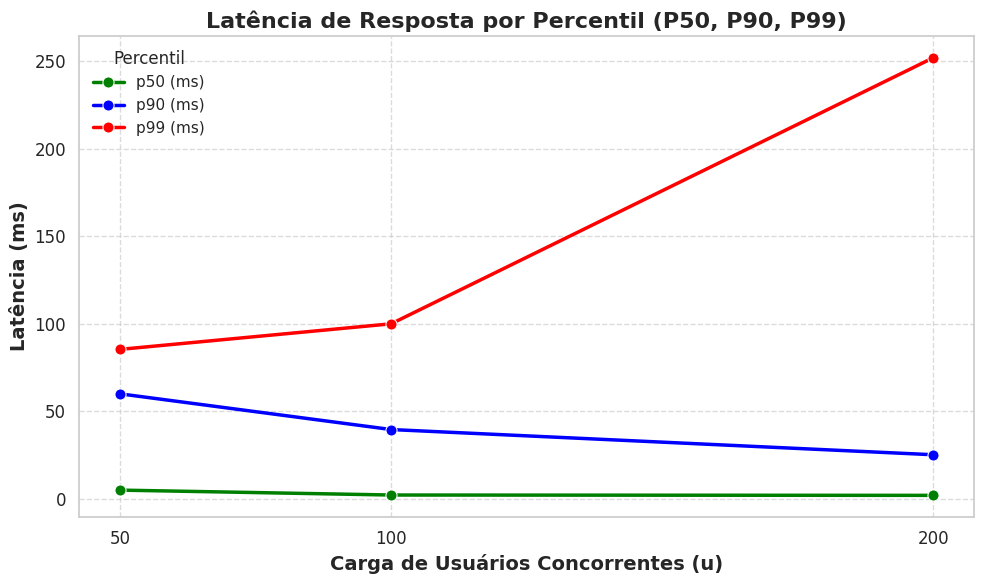

In [31]:
# --- 2.4 Latência por Percentil (P50, P90, P99) ---
# Usamos dados consolidados do seu script de análise (P50, P90, P99 devem ser incluídos)
# NOTA: O script de análise anterior só calculou a Média e Máxima.
# Seus arquivos *_stats.csv contêm as colunas '50%', '90%', '99%', use-os!

def load_percentile_data(scenarios):
    """Carrega e calcula a média dos percentis P50, P90, P99 de todas as repetições."""
    df_percentile_list = []
    
    for scenario, data in scenarios.items():
        pattern = data["pattern"]
        users = data["users"]
        all_files = glob.glob(pattern)
        
        df_list = []
        for f in all_files:
            try:
                df = pd.read_csv(f)
                df_list.append(df.loc[df['Name'] == 'Aggregated'])
            except:
                continue
                
        if df_list:
            combined_df = pd.concat(df_list)
            # Garante que as colunas são numéricas
            combined_df['50%'] = pd.to_numeric(combined_df['50%'], errors='coerce')
            combined_df['90%'] = pd.to_numeric(combined_df['90%'], errors='coerce')
            combined_df['99%'] = pd.to_numeric(combined_df['99%'], errors='coerce')

            avg_p = {
                'Usuários (u)': users,
                'p50 (ms)': combined_df['50%'].mean().round(2),
                'p90 (ms)': combined_df['90%'].mean().round(2),
                'p99 (ms)': combined_df['99%'].mean().round(2)
            }
            df_percentile_list.append(avg_p)
            
    return pd.DataFrame(df_percentile_list)

df_percentis = load_percentile_data(SCENARIOS)
df_percentis_melt = df_percentis.melt(id_vars='Usuários (u)', 
                                      value_vars=['p50 (ms)', 'p90 (ms)', 'p99 (ms)'],
                                      var_name='Percentil', 
                                      value_name='Latência (ms)')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_percentis_melt, x='Usuários (u)', y='Latência (ms)', hue='Percentil', 
             marker='o', markersize=8, linewidth=2.5, palette=['green', 'blue', 'red'])

plt.title('Latência de Resposta por Percentil (P50, P90, P99)')
plt.xlabel('Carga de Usuários Concorrentes (u)')
plt.ylabel('Latência (ms)')
plt.xticks(df_percentis['Usuários (u)'])
plt.legend(title='Percentil')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipykernel_13284/4105991240.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Scenario', y='Latência Média (ms)', data=df_box_plot, palette='coolwarm')


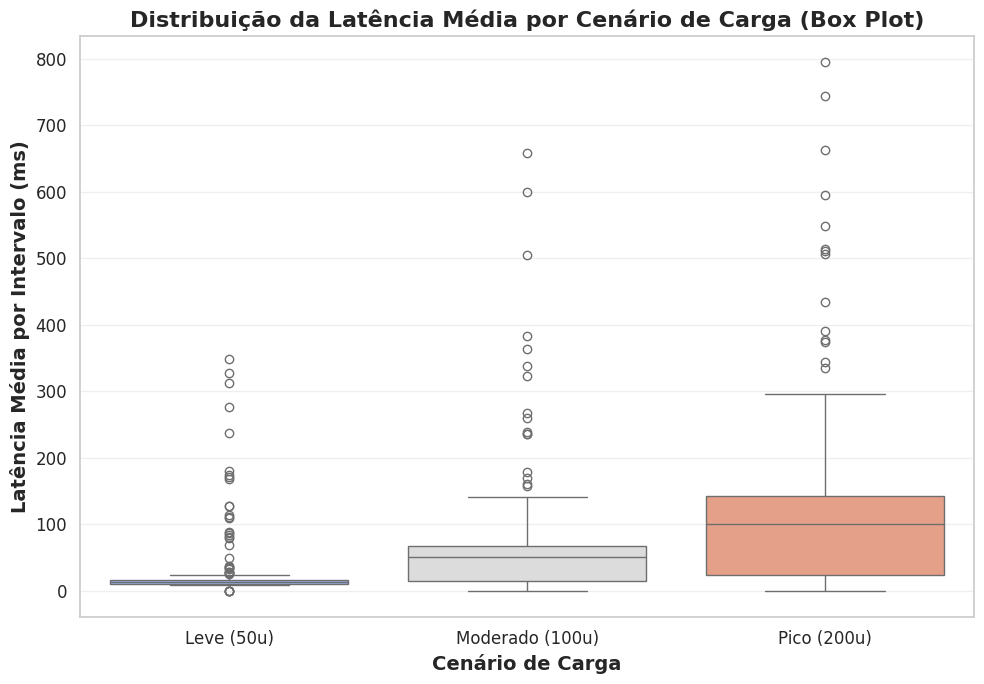

In [32]:
# --- 2.5 Distribuição de Latência (Box Plot) ---

# Reutilizamos a função load_history_data, mas pegamos a coluna Total Average Response Time
def load_avg_latency_for_box_plot(scenarios):
    """Carrega a Latência Média Agregada por segundo de todas as repetições."""
    df_box_list = []
    
    for scenario, data in scenarios.items():
        pattern = data["pattern"].replace('_stats.csv', '_stats_history.csv')
        all_files = glob.glob(pattern)
        
        for f in all_files:
            try:
                df = pd.read_csv(f)
                df = df[df['Name'] == 'Aggregated'].copy()
                df['Scenario'] = f"{scenario} ({data['users']}u)"
                # Latência Média no intervalo de 1 segundo
                df_box_list.append(df[['Scenario', 'Total Average Response Time']].rename(columns={'Total Average Response Time': 'Latência Média (ms)'}))
            except:
                continue

    return pd.concat(df_box_list, ignore_index=True)

df_box_plot = load_avg_latency_for_box_plot(SCENARIOS)

if not df_box_plot.empty:
    plt.figure(figsize=(10, 7))
    sns.boxplot(x='Scenario', y='Latência Média (ms)', data=df_box_plot, palette='coolwarm')
    
    plt.title('Distribuição da Latência Média por Cenário de Carga (Box Plot)')
    plt.xlabel('Cenário de Carga')
    plt.ylabel('Latência Média por Intervalo (ms)')
    plt.tight_layout()
    plt.show()

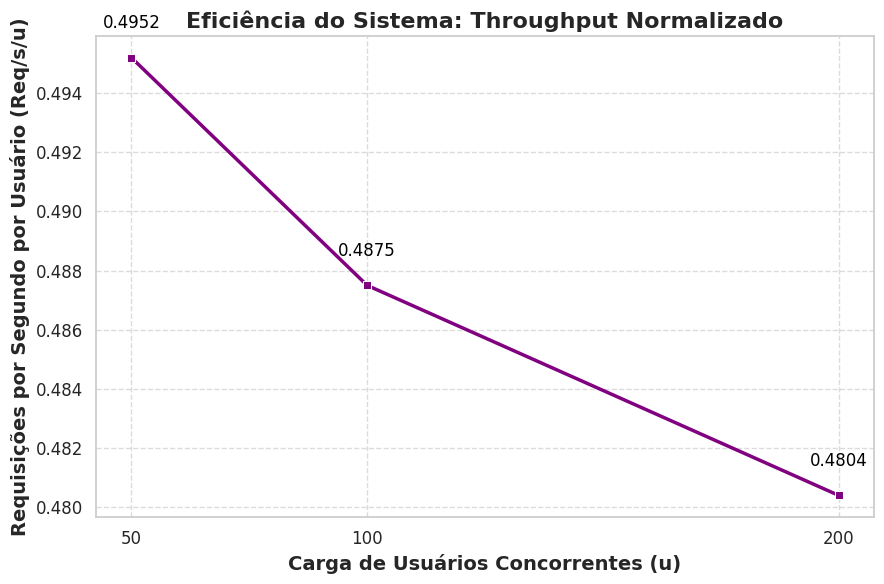

In [33]:
# --- 2.6 Throughput Normalizado (Req/s por Usuário) ---

# Cria a nova métrica no DataFrame consolidado
df_consolidado['Req/s por Usuário'] = (df_consolidado['Requisições/s'] / df_consolidado['Usuários (u)']).round(4)

plt.figure(figsize=(9, 6))
sns.lineplot(x='Usuários (u)', y='Req/s por Usuário', data=df_consolidado, marker='s', color='purple', linewidth=2.5)

# Adiciona o valor exato nos pontos
for index, row in df_consolidado.iterrows():
    plt.text(row['Usuários (u)'], row['Req/s por Usuário'] + 0.001, f"{row['Req/s por Usuário']:.4f}", color='black', ha="center")

plt.title('Eficiência do Sistema: Throughput Normalizado')
plt.xlabel('Carga de Usuários Concorrentes (u)')
plt.ylabel('Requisições por Segundo por Usuário (Req/s/u)')
plt.xticks(df_consolidado['Usuários (u)'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Tabela Consolidada (Média das Repetições) ---
| Cenário   |   Usuários (u) |   Média Latência (ms) |   Máxima Latência (ms) |   Requisições/s |   Erros (%) |
|:----------|---------------:|----------------------:|-----------------------:|----------------:|------------:|
| Leve      |             50 |                 19.74 |                1463.74 |           24.76 |      0      |
| Moderado  |            100 |                 50.2  |               10082.8  |           48.75 |     53.9923 |
| Pico      |            200 |                 81.81 |               10175    |           96.09 |     68.8738 |


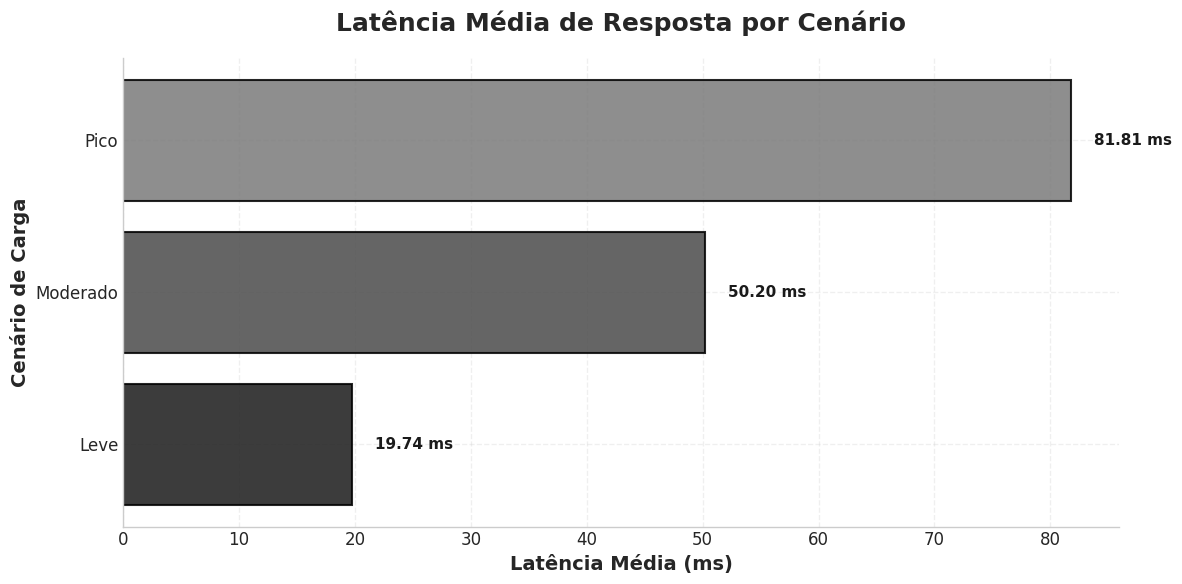

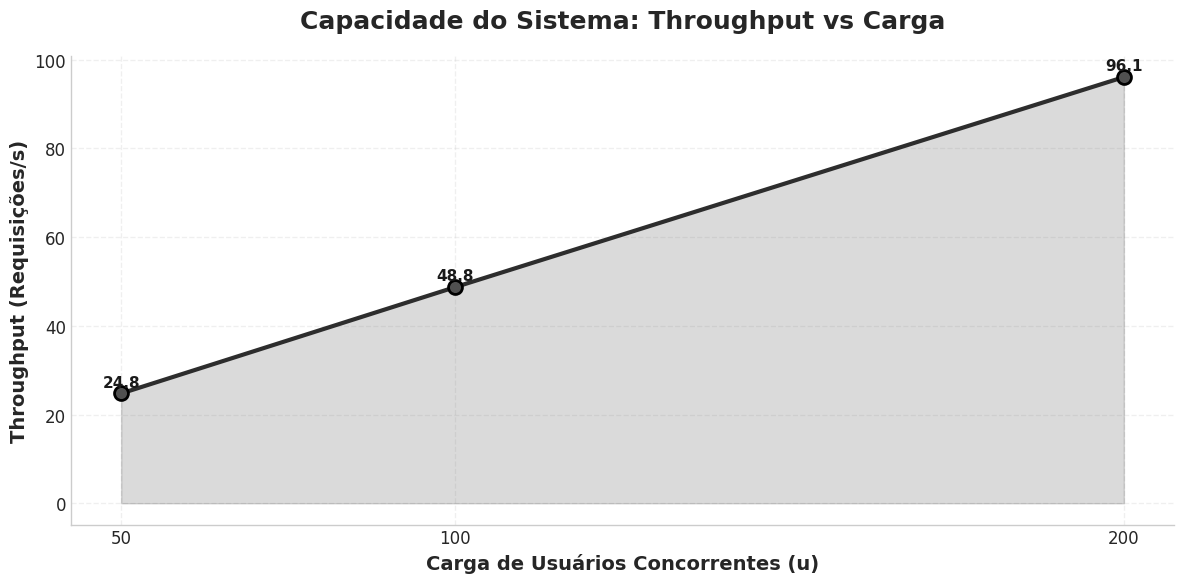

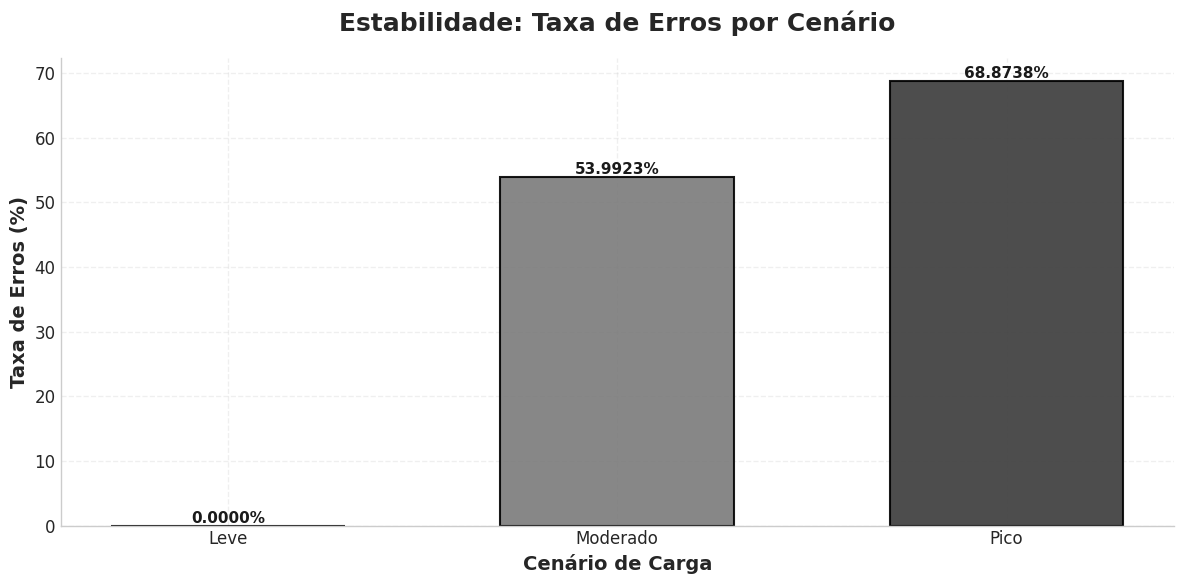

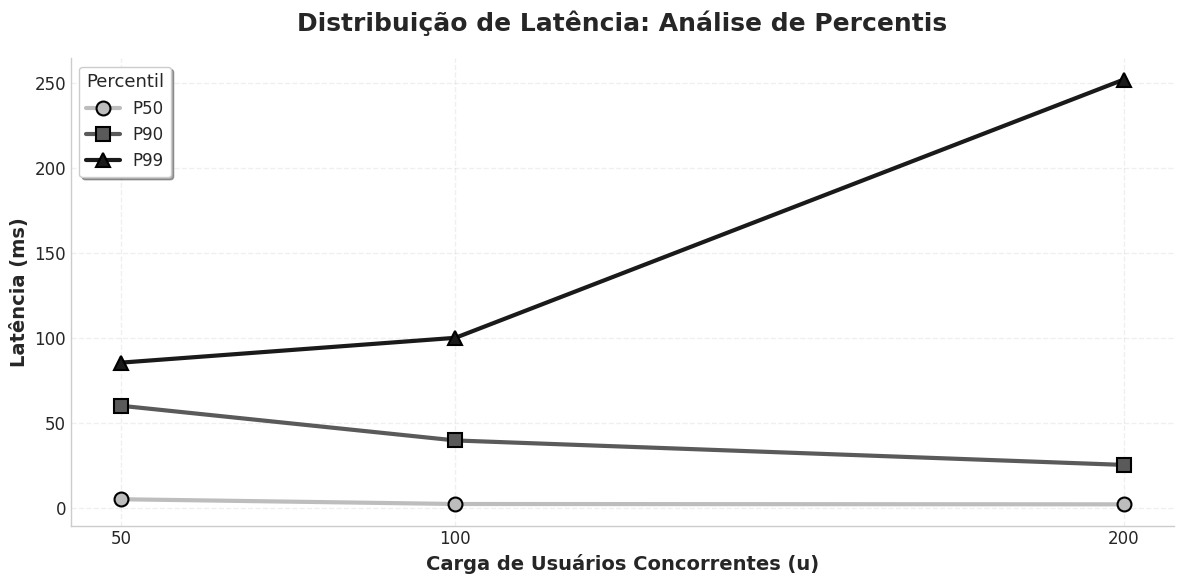

/tmp/ipykernel_13284/1647459323.py:257: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data,


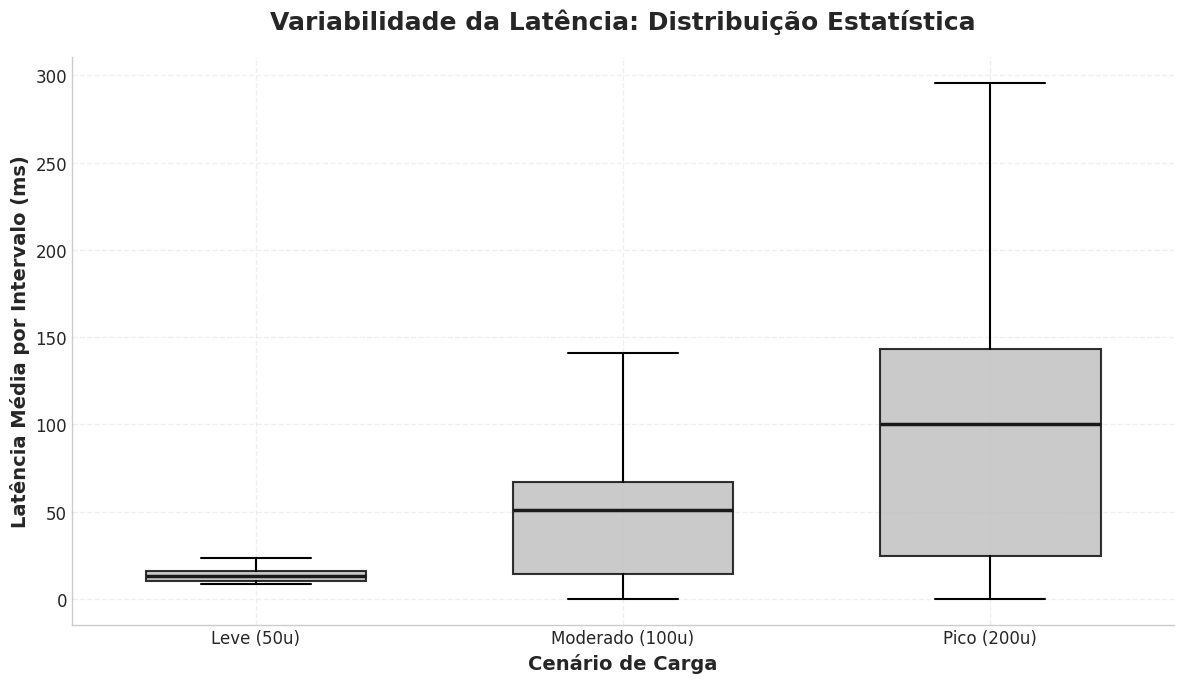

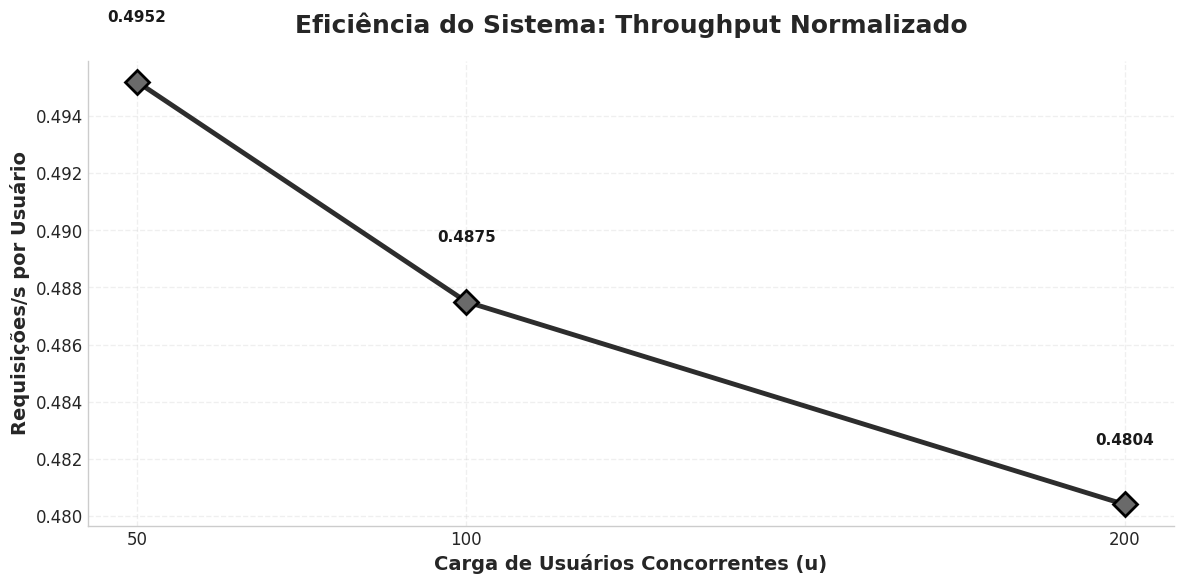


✓ Análise completa com gráficos modernos em escala de cinza gerada com sucesso!


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Configuração de Estilo Moderno e Minimalista
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("gray")

# Configurações globais para estilo profissional
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans']
})

# Paleta de cores em escala de cinza personalizada
GRAY_PALETTE = ['#2d2d2d', '#505050', '#737373', '#969696', '#bdbdbd']
GRADIENT_GRAY = ['#1a1a1a', '#4a4a4a', '#7a7a7a']

# Diretórios e cenários
BASE_DIR = os.getcwd()
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

SCENARIOS = {
    "Leve": {"users": 50, "pattern": "results/leve/*_stats.csv"},
    "Moderado": {"users": 100, "pattern": "results/medio/*_stats.csv"},
    "Pico": {"users": 200, "pattern": "results/pico/*_stats.csv"}
}

def load_and_aggregate_results(scenarios):
    """Carrega, processa e agrega os dados de todas as repetições."""
    RESULT_METRICS = []
    
    for scenario, data in scenarios.items():
        pattern = data["pattern"]
        users = data["users"]
        all_files = glob.glob(pattern)
        
        if not all_files:
            print(f"Aviso: Nenhum arquivo encontrado para o cenário {scenario}.")
            continue

        df_list = []
        for f in all_files:
            try:
                df = pd.read_csv(f)
                aggregated_row = df.loc[df['Name'] == 'Aggregated']
                if not aggregated_row.empty:
                    df_list.append(aggregated_row)
            except Exception as e:
                print(f"Erro ao processar o arquivo {f}: {e}")
                
        if not df_list:
            continue

        combined_df = pd.concat(df_list)

        for col in ['Average Response Time', 'Max Response Time', 'Requests/s', 'Failure Count', 'Request Count']:
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

        avg_latency = combined_df['Average Response Time'].mean().round(2)
        max_latency_absolute = combined_df['Max Response Time'].max().round(2)
        avg_req_s = combined_df['Requests/s'].mean().round(2)
        
        total_requests = combined_df['Request Count'].sum()
        total_failures = combined_df['Failure Count'].sum()
        
        avg_failure_rate = (total_failures / total_requests) * 100 if total_requests > 0 else 0.0

        avg_data = {
            'Cenário': scenario,
            'Usuários (u)': users,
            'Média Latência (ms)': avg_latency,
            'Máxima Latência (ms)': max_latency_absolute,
            'Requisições/s': avg_req_s,
            'Erros (%)': round(avg_failure_rate, 4)
        }
        RESULT_METRICS.append(avg_data)

    return pd.DataFrame(RESULT_METRICS)

df_consolidado = load_and_aggregate_results(SCENARIOS)
print("--- Tabela Consolidada (Média das Repetições) ---")
print(df_consolidado.to_markdown(index=False))

# === GRÁFICO 1: Latência Média (Barras Horizontais Modernas) ===
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.barh(df_consolidado['Cenário'], df_consolidado['Média Latência (ms)'], 
               color=GRADIENT_GRAY, edgecolor='black', linewidth=1.5, alpha=0.85)

# Adiciona valores nas barras
for i, (idx, row) in enumerate(df_consolidado.iterrows()):
    ax.text(row['Média Latência (ms)'] + 2, i, f"{row['Média Latência (ms)']:.2f} ms", 
            va='center', fontweight='bold', fontsize=11, color='#1a1a1a')

ax.set_xlabel('Latência Média (ms)', fontsize=14, fontweight='bold')
ax.set_ylabel('Cenário de Carga', fontsize=14, fontweight='bold')
ax.set_title('Latência Média de Resposta por Cenário', fontsize=18, fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# === GRÁFICO 2: Throughput com Área Sombreada ===
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_consolidado['Usuários (u)'], df_consolidado['Requisições/s'], 
        marker='o', markersize=10, linewidth=3, color='#2d2d2d', 
        markerfacecolor='#505050', markeredgecolor='black', markeredgewidth=2)

ax.fill_between(df_consolidado['Usuários (u)'], df_consolidado['Requisições/s'], 
                alpha=0.2, color='#4a4a4a')

# Adiciona valores nos pontos
for idx, row in df_consolidado.iterrows():
    ax.text(row['Usuários (u)'], row['Requisições/s'] + 1.5, f"{row['Requisições/s']:.1f}", 
            ha='center', fontweight='bold', fontsize=11, color='#1a1a1a')

ax.set_xlabel('Carga de Usuários Concorrentes (u)', fontsize=14, fontweight='bold')
ax.set_ylabel('Throughput (Requisições/s)', fontsize=14, fontweight='bold')
ax.set_title('Capacidade do Sistema: Throughput vs Carga', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(df_consolidado['Usuários (u)'])
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# === GRÁFICO 3: Taxa de Erros (Barras Minimalistas) ===
fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(df_consolidado['Cenário'], df_consolidado['Erros (%)'], 
              color=['#bdbdbd', '#7a7a7a', '#3a3a3a'], edgecolor='black', 
              linewidth=1.5, alpha=0.9, width=0.6)

# Adiciona valores no topo
for bar, (idx, row) in zip(bars, df_consolidado.iterrows()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.0002,
            f'{row["Erros (%)"]:.4f}%', ha='center', va='bottom', 
            fontweight='bold', fontsize=11, color='#1a1a1a')

ax.set_ylabel('Taxa de Erros (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Cenário de Carga', fontsize=14, fontweight='bold')
ax.set_title('Estabilidade: Taxa de Erros por Cenário', fontsize=18, fontweight='bold', pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# === GRÁFICO 4: Latência por Percentil (Linhas Elegantes) ===
def load_percentile_data(scenarios):
    df_percentile_list = []
    
    for scenario, data in scenarios.items():
        pattern = data["pattern"]
        users = data["users"]
        all_files = glob.glob(pattern)
        
        df_list = []
        for f in all_files:
            try:
                df = pd.read_csv(f)
                df_list.append(df.loc[df['Name'] == 'Aggregated'])
            except:
                continue
                
        if df_list:
            combined_df = pd.concat(df_list)
            combined_df['50%'] = pd.to_numeric(combined_df['50%'], errors='coerce')
            combined_df['90%'] = pd.to_numeric(combined_df['90%'], errors='coerce')
            combined_df['99%'] = pd.to_numeric(combined_df['99%'], errors='coerce')

            avg_p = {
                'Usuários (u)': users,
                'p50 (ms)': combined_df['50%'].mean().round(2),
                'p90 (ms)': combined_df['90%'].mean().round(2),
                'p99 (ms)': combined_df['99%'].mean().round(2)
            }
            df_percentile_list.append(avg_p)
            
    return pd.DataFrame(df_percentile_list)

df_percentis = load_percentile_data(SCENARIOS)
df_percentis_melt = df_percentis.melt(id_vars='Usuários (u)', 
                                      value_vars=['p50 (ms)', 'p90 (ms)', 'p99 (ms)'],
                                      var_name='Percentil', 
                                      value_name='Latência (ms)')

fig, ax = plt.subplots(figsize=(12, 6))

styles = [
    {'color': '#bdbdbd', 'linestyle': '-', 'linewidth': 3, 'marker': 'o'},
    {'color': '#5a5a5a', 'linestyle': '-', 'linewidth': 3, 'marker': 's'},
    {'color': '#1a1a1a', 'linestyle': '-', 'linewidth': 3, 'marker': '^'}
]

for i, percentil in enumerate(['p50 (ms)', 'p90 (ms)', 'p99 (ms)']):
    data = df_percentis_melt[df_percentis_melt['Percentil'] == percentil]
    ax.plot(data['Usuários (u)'], data['Latência (ms)'], 
            label=percentil.replace(' (ms)', '').upper(), 
            markersize=10, markeredgecolor='black', markeredgewidth=1.5,
            **styles[i])

ax.set_xlabel('Carga de Usuários Concorrentes (u)', fontsize=14, fontweight='bold')
ax.set_ylabel('Latência (ms)', fontsize=14, fontweight='bold')
ax.set_title('Distribuição de Latência: Análise de Percentis', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(df_percentis['Usuários (u)'])
ax.legend(title='Percentil', fontsize=12, title_fontsize=13, frameon=True, 
          fancybox=True, shadow=True, loc='upper left')
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# === GRÁFICO 5: Box Plot Minimalista ===
def load_avg_latency_for_box_plot(scenarios):
    df_box_list = []
    
    for scenario, data in scenarios.items():
        pattern = data["pattern"].replace('_stats.csv', '_stats_history.csv')
        all_files = glob.glob(pattern)
        
        for f in all_files:
            try:
                df = pd.read_csv(f)
                df = df[df['Name'] == 'Aggregated'].copy()
                df['Scenario'] = f"{scenario} ({data['users']}u)"
                df_box_list.append(df[['Scenario', 'Total Average Response Time']].rename(
                    columns={'Total Average Response Time': 'Latência Média (ms)'}))
            except:
                continue

    return pd.concat(df_box_list, ignore_index=True)

df_box_plot = load_avg_latency_for_box_plot(SCENARIOS)

if not df_box_plot.empty:
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Prepara os dados para o boxplot
    box_data = [df_box_plot[df_box_plot['Scenario'] == s]['Latência Média (ms)'].values 
                for s in df_box_plot['Scenario'].unique()]
    
    bp = ax.boxplot(box_data,
                     labels=df_box_plot['Scenario'].unique(),
                     patch_artist=True,
                     widths=0.6,
                     showfliers=False,  # Remove outliers
                     sym='',  # Garantia adicional para não mostrar outliers
                     boxprops=dict(facecolor='#bdbdbd', edgecolor='black', linewidth=1.5, alpha=0.8),
                     whiskerprops=dict(color='black', linewidth=1.5),
                     capprops=dict(color='black', linewidth=1.5),
                     medianprops=dict(color='#1a1a1a', linewidth=2.5))
    
    ax.set_ylabel('Latência Média por Intervalo (ms)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Cenário de Carga', fontsize=14, fontweight='bold')
    ax.set_title('Variabilidade da Latência: Distribuição Estatística', fontsize=18, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    plt.tight_layout()
    plt.show()

# === GRÁFICO 6: Throughput Normalizado (Linha com Marcadores) ===
df_consolidado['Req/s por Usuário'] = (df_consolidado['Requisições/s'] / df_consolidado['Usuários (u)']).round(4)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_consolidado['Usuários (u)'], df_consolidado['Req/s por Usuário'], 
        marker='D', markersize=12, linewidth=3.5, color='#2d2d2d',
        markerfacecolor='#6a6a6a', markeredgecolor='black', markeredgewidth=2)

for idx, row in df_consolidado.iterrows():
    ax.text(row['Usuários (u)'], row['Req/s por Usuário'] + 0.002, 
            f"{row['Req/s por Usuário']:.4f}", ha='center', va='bottom',
            fontweight='bold', fontsize=11, color='#1a1a1a')

ax.set_xlabel('Carga de Usuários Concorrentes (u)', fontsize=14, fontweight='bold')
ax.set_ylabel('Requisições/s por Usuário', fontsize=14, fontweight='bold')
ax.set_title('Eficiência do Sistema: Throughput Normalizado', fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(df_consolidado['Usuários (u)'])
ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n✓ Análise completa com gráficos modernos em escala de cinza gerada com sucesso!")